<a href="https://colab.research.google.com/github/DraPraks/CheXagent/blob/main/usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import io

import requests
import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig


# step 2: Load Processor and Model
processor = AutoProcessor.from_pretrained("StanfordAIMI/CheXagent-8b", trust_remote_code=True)
generation_config = GenerationConfig.from_pretrained("StanfordAIMI/CheXagent-8b")
model = AutoModelForCausalLM.from_pretrained("StanfordAIMI/CheXagent-8b", torch_dtype=dtype, trust_remote_code=True)




model-00001-of-00007.safetensors:  50%|#####     | 2.24G/4.48G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7884b44e1080>

In [8]:
model.to(device)

CheXagentForConditionalGeneration(
  (vision_model): CheXagentVisionModel(
    (embeddings): CheXagentVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): CheXagentEncoder(
      (layers): ModuleList(
        (0-39): 40 x CheXagentEncoderLayer(
          (self_attn): CheXagentAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): CheXagentMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (

In [4]:
import requests
from PIL import Image, UnidentifiedImageError
import io

def fetch_and_open_image(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, allow_redirects=True)

        # Check if the request was successful
        if response.status_code != 200:
            print(f"Failed to fetch image. Status code: {response.status_code}")
            return None

        # Verify the Content-Type is an image
        content_type = response.headers.get('Content-Type', '')
        if 'image' not in content_type:
            print(f"URL did not return an image. Content-Type: {content_type}")
            return None

        # Attempt to open the image
        try:
            image = Image.open(io.BytesIO(response.content)).convert("RGB")
            print("Image fetched and opened successfully.")
            return image
        except UnidentifiedImageError:
            print("Cannot identify image file. The data may not be a valid image.")
            return None
    except requests.RequestException as e:
        print(f"An error occurred while fetching the image: {e}")
        return None

# Usage
image_path = "https://upload.wikimedia.org/wikipedia/commons/3/3b/Pleural_effusion-Metastatic_breast_carcinoma_Case_166_%285477628658%29.jpg"
image = fetch_and_open_image(image_path)

if image:
    images = [image]
    # Proceed with further processing
else:
    print("Image could not be processed.")


Image fetched and opened successfully.


In [9]:

# step 4: Generate the Findings section
prompt = f'Describe "Airway"'
inputs = processor(images=images, text=f" USER: <s>{prompt} ASSISTANT: <s>", return_tensors="pt").to(device=device, dtype=dtype)
output = model.generate(**inputs, generation_config=generation_config)[0]
response = processor.tokenizer.decode(output, skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [10]:
print(response)

The hilar contours are unremarkable.


Using device: cuda
Using data type: torch.float16
Image fetched and opened successfully.
Enter your prompt (e.g., "Describe "Airway"): Describe and find anomalies


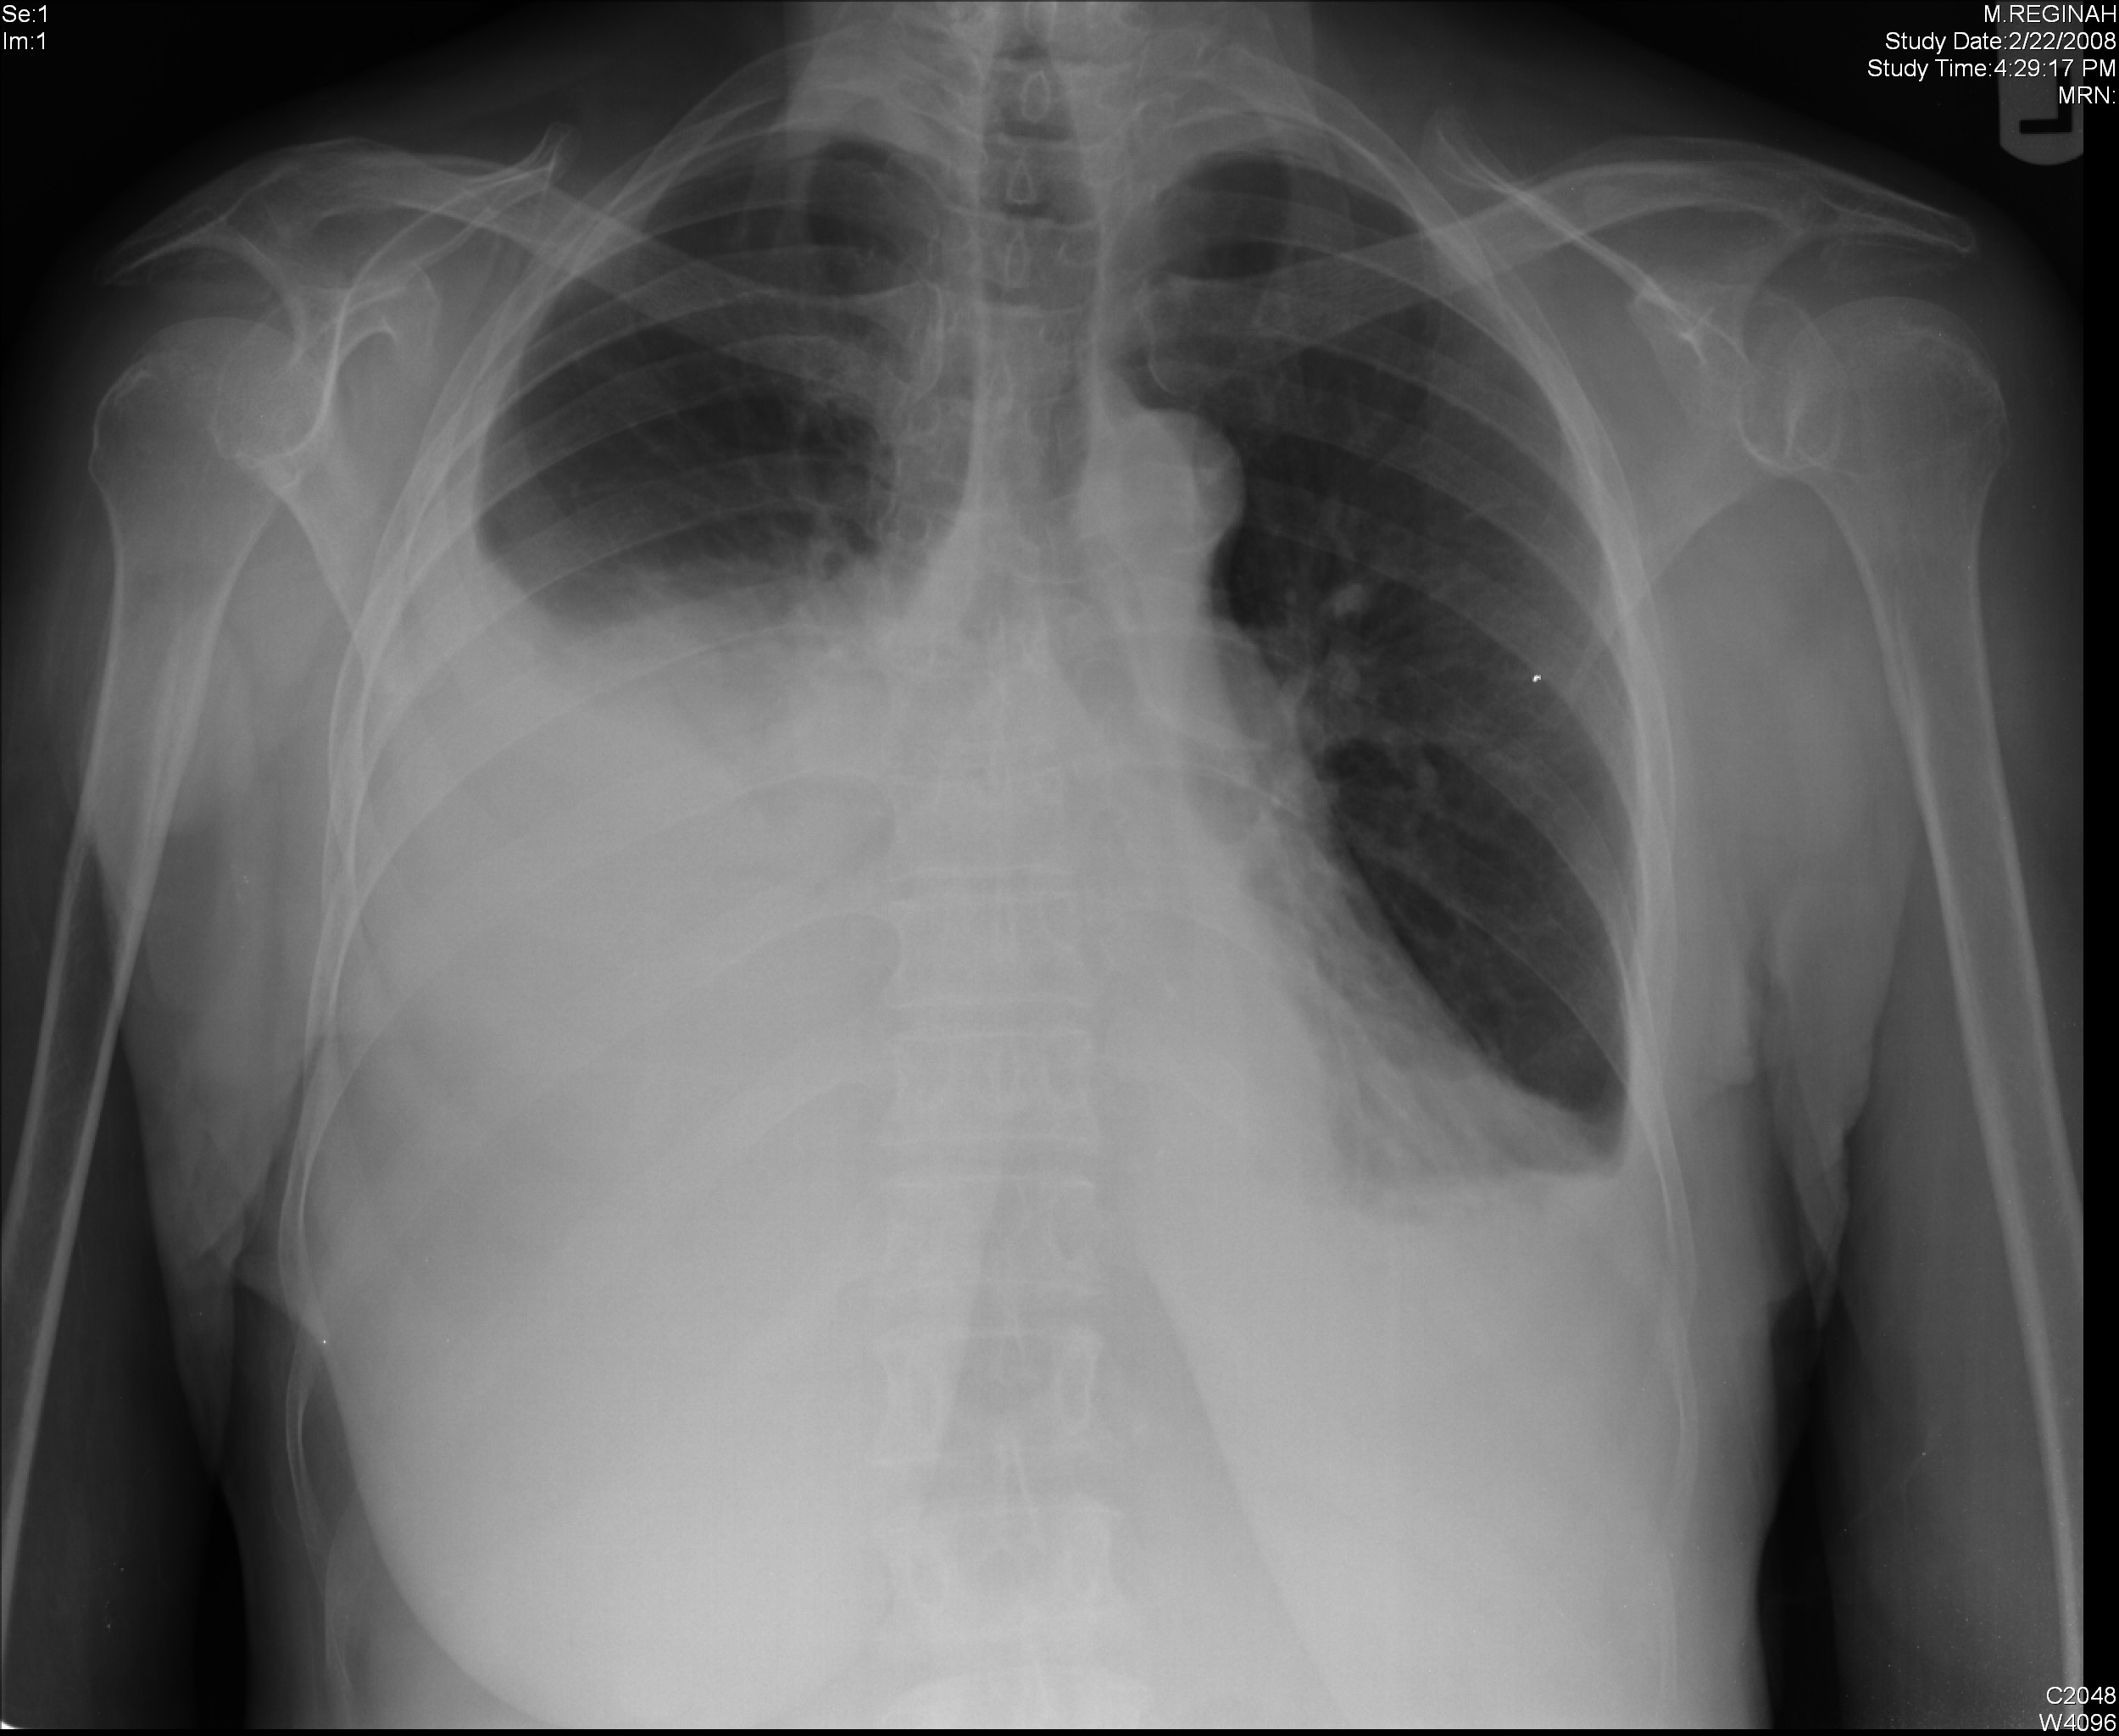

/root/.cache/huggingface/modules/transformers_modules/StanfordAIMI/CheXagent-8b/4934e91451945c8218c267aae9c34929a7677829/processing_chexagent.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(pixel_values) for pixel_values in encoding_image_processor["pixel_values"]]
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Generated Response:
 There is a large right pleural effusion with overlying atelectasis. There is a small left pleural effusion with overlying atelectasis. The lungs are otherwise clear. There is no pneumothorax. The cardiomediastinal silhouette is within normal limits.


In [14]:
import io
import requests
import torch
from PIL import Image, UnidentifiedImageError
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig

# For displaying images in Jupyter Notebooks
try:
    from IPython.display import display
    in_notebook = True
except ImportError:
    in_notebook = False

# Define device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dtype based on device
dtype = torch.float16 if device.type == 'cuda' else torch.float32
print(f"Using data type: {dtype}")

def fetch_and_display_image(url):
    """
    Fetches an image from a URL and displays it.

    Args:
        url (str): URL of the image.

    Returns:
        Image object if successful, else None.
    """
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, allow_redirects=True)

        # Check if the request was successful
        if response.status_code != 200:
            print(f"Failed to fetch image. Status code: {response.status_code}")
            return None

        # Verify the Content-Type is an image
        content_type = response.headers.get('Content-Type', '')
        if 'image' not in content_type:
            print(f"URL did not return an image. Content-Type: {content_type}")
            return None

        # Attempt to open the image
        try:
            image = Image.open(io.BytesIO(response.content)).convert("RGB")
            print("Image fetched and opened successfully.")

            # Display the image
            if in_notebook:
                display(image)
            else:
                image.show()

            return image
        except UnidentifiedImageError:
            print("Cannot identify image file. The data may not be a valid image.")
            return None
    except requests.RequestException as e:
        print(f"An error occurred while fetching the image: {e}")
        return None

# URL of the image to fetch
image_url = "https://upload.wikimedia.org/wikipedia/commons/3/3b/Pleural_effusion-Metastatic_breast_carcinoma_Case_166_%285477628658%29.jpg"

# Fetch and display the image
image = fetch_and_display_image(image_url)

if image:
    images = [image]
else:
    raise ValueError("Image could not be processed.")

# Accept user input for the prompt
prompt = input('Enter your prompt (e.g., "Describe "Airway"): ').strip()

if not prompt:
    raise ValueError("Prompt cannot be empty.")

# Load Processor and Generation Config
# processor = AutoProcessor.from_pretrained("StanfordAIMI/CheXagent-8b", trust_remote_code=True)
# generation_config = GenerationConfig.from_pretrained("StanfordAIMI/CheXagent-8b")

# Load Model
#model = AutoModelForCausalLM.from_pretrained(
    #"StanfordAIMI/CheXagent-8b",
    #torch_dtype=dtype,
    #device_map="auto",  # Automatically map model to available devices
    #trust_remote_code=True
#)
#model.to(device)  # Ensure model is on the correct device

# Prepare the input text
input_text = f" USER: <s>{prompt} ASSISTANT: <s>"

# Process inputs
inputs = processor(
    images=images,
    text=input_text,
    return_tensors="pt"
)

# Move inputs to the correct device and dtype
inputs = inputs.to(device=device, dtype=dtype)

# Generate output
try:
    output = model.generate(**inputs, generation_config=generation_config)[0]
    response = processor.tokenizer.decode(output, skip_special_tokens=True)
    print("\nGenerated Response:\n", response)
except RuntimeError as e:
    print(f"An error occurred during generation: {e}")


Using device: cuda
Using data type: torch.float16
Loading processor and generation configuration...
Processor and generation configuration loaded.
Loading model...
Model loaded successfully.
Image fetched and opened successfully.


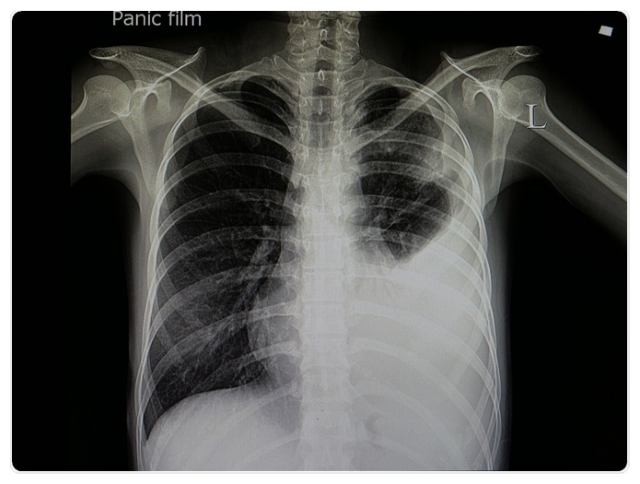

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Generated Response:
 There is a large left pleural effusion with adjacent atelectasis. The right lung is clear. There is no pneumothorax. The cardiomediastinal silhouette is within normal limits.


In [33]:
import io
import requests
import torch
from PIL import Image, UnidentifiedImageError
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig
import matplotlib.pyplot as plt

# Attempt to import IPython.display for inline image display
try:
    from IPython.display import display
    IN_NOTEBOOK = True
except ImportError:
    IN_NOTEBOOK = False


class ImageHandler:
    """
    Handles fetching and displaying images from a URL.
    """

    def __init__(self):
        self.image = None

    def fetch_image(self, url):
        """
        Fetches an image from a URL.

        Args:
            url (str): URL of the image.

        Returns:
            Image object if successful, else None.
        """
        try:
            headers = {'User-Agent': 'Mozilla/5.0'}
            response = requests.get(url, headers=headers, allow_redirects=True)

            # Check if the request was successful
            if response.status_code != 200:
                print(f"Failed to fetch image. Status code: {response.status_code}")
                return None

            # Verify the Content-Type is an image
            content_type = response.headers.get('Content-Type', '')
            if 'image' not in content_type:
                print(f"URL did not return an image. Content-Type: {content_type}")
                return None

            # Attempt to open the image
            try:
                image = Image.open(io.BytesIO(response.content)).convert("RGB")
                print("Image fetched and opened successfully.")
                self.image = image
                return image
            except UnidentifiedImageError:
                print("Cannot identify image file. The data may not be a valid image.")
                return None
        except requests.RequestException as e:
            print(f"An error occurred while fetching the image: {e}")
            return None

    def display_image(self):
        """
        Displays the fetched image using matplotlib.
        """
        if self.image is None:
            print("No image to display.")
            return

        plt.figure(figsize=(8, 8))
        plt.imshow(self.image)
        plt.axis('off')  # Hide axis
        plt.show(block=False)  # Non-blocking show
        plt.pause(0.001)  # Pause to allow the plot to render
        plt.close()  # Close the figure to prevent interference


class ModelHandler:
    """
    Manages loading the model, processing inputs, and generating responses.
    """

    def __init__(self, model_name="StanfordAIMI/CheXagent-8b"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.dtype = torch.float16 if self.device.type == 'cuda' else torch.float32
        print(f"Using data type: {self.dtype}")

        # Load Processor and Generation Config
        print("Loading processor and generation configuration...")
        self.processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
        self.generation_config = GenerationConfig.from_pretrained(model_name)
        print("Processor and generation configuration loaded.")

        # Load Model
        print("Loading model...")
        self.model = model
        print("Model loaded successfully.")

    def generate_response(self, images, prompt):
        """
        Generates a response based on the provided images and prompt.

        Args:
            images (list): List of PIL Image objects.
            prompt (str): User prompt.

        Returns:
            str: Generated response from the model.
        """
        if not images:
            raise ValueError("No images provided for processing.")

        # Prepare the input text
        input_text = f" USER: <s>{prompt} ASSISTANT: <s>"

        # Process inputs
        inputs = self.processor(
            images=images,
            text=input_text,
            return_tensors="pt"
        )

        # Move inputs to the correct device and dtype
        inputs = inputs.to(device=self.device, dtype=self.dtype)

        # Generate output
        try:
            output = self.model.generate(**inputs, generation_config=self.generation_config)[0]
            response = self.processor.tokenizer.decode(output, skip_special_tokens=True)
            return response
        except RuntimeError as e:
            print(f"An error occurred during generation: {e}")
            return None


class Application:
    """
    Coordinates the image handling and model interaction.
    """

    def __init__(self, image_url, model_name="StanfordAIMI/CheXagent-8b"):
        self.image_url = image_url
        self.image_handler = ImageHandler()
        self.model_handler = ModelHandler(model_name=model_name)

    def run(self):
        """
        Executes the application workflow.
        """

        # Fetch image
        image = self.image_handler.fetch_image(self.image_url)

        # Accept user input for the prompt
        try:
            # prompt = input('Enter your prompt (e.g., "Describe "Airway"): ').strip()
            prompt = f"""
Write a professional clinical report in plain medical language suitable for a radiologist or physician. Use the following structure:
"""

            if not prompt:
                raise ValueError("Prompt cannot be empty.")
        except KeyboardInterrupt:
            print("\nOperation cancelled by user.")
            return

        if image:
            # Display image
            self.image_handler.display_image()
        else:
            print("Failed to fetch and display the image.")
            return



        # Generate and display the response
        response = self.model_handler.generate_response([image], prompt)
        if response:
            print("\nGenerated Response:\n", response)
        else:
            print("Failed to generate a response.")


if __name__ == "__main__":
    # Example usage
    image_url = "https://d2jx2rerrg6sh3.cloudfront.net/image-handler/picture/2020/6/shutterstock_786937069.jpg"
    app = Application(image_url=image_url)
    app.run()
